In [22]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('PySparkTest').getOrCreate()

from IPython.display import display, HTML
display(HTML("<style>.jp-Cell-outputArea { text-align: center; }</style>"))

In [2]:
from pyspark.sql import types as T
from pyspark.sql.window import Window
from pyspark.sql import functions as F

TOP_N_RECOMMENDATIONS = 3
TOP_N_CLUSTER_RECOMMENDATIONS = 3
TOP_N_OFFERS = 2
THRESH = 0.9

# Read Files

In [3]:
path_rf_predictions = '../data/trusted/rf_output_model'
path_km_predictions = '../data/trusted/km_output_model'
path_freq_bayes = '../data/trusted/freq_bayes'
path_output_allocation = "../data/refined/allocation"

df_rf_predictions = spark.read.format("parquet").option("header", "true").option("inferSchema", "true").load(path_rf_predictions)
df_km_predictions = spark.read.format("parquet").option("header", "true").option("inferSchema", "true").load(path_km_predictions)
df_freq_bayes = spark.read.format("parquet").option("header", "true").option("inferSchema", "true").load(path_freq_bayes)

In [4]:
df_freq_bayes.show(5)

+--------------------+-------------+--------------------+-------------------+----------------+----------+
|           client_id|   offer_type|            offer_id|qtd_offer_completed|offer_type_count|freq_bayes|
+--------------------+-------------+--------------------+-------------------+----------------+----------+
|0009655768c64bdeb...|     discount|2906b810c7d441179...|                  1|               2|       0.5|
|0009655768c64bdeb...|informational|3f207df678b143eea...|                  0|               2|       0.0|
|0009655768c64bdeb...|informational|5a8bc65990b245e5a...|                  0|               2|       0.0|
|0009655768c64bdeb...|         bogo|f19421c1d4aa40978...|                  1|               1|       1.0|
|0009655768c64bdeb...|     discount|fafdcd668e3743c1b...|                  1|               2|       0.5|
+--------------------+-------------+--------------------+-------------------+----------------+----------+
only showing top 5 rows


In [5]:
df_rf_predictions.select('client_id', 'offer_id').distinct().count(), df_freq_bayes.select('client_id', 'offer_id').distinct().count()

(63288, 63288)

### Gerando Score de Propensão e Recomendações

In [6]:
df_offer_score = df_rf_predictions.join(df_freq_bayes, on=['client_id', 'offer_id'], how='inner')\
                           .withColumn("offer_score", F.col("freq_bayes")*F.col("y_proba_class1"))\
                           .withColumn("ranking", F.row_number().over(Window.partitionBy("client_id")\
                                                                            .orderBy(F.col("offer_score").desc(), 
                                                                                     F.col("y_proba_class1").desc(),
                                                                                     F.col("freq_bayes").desc())))\
                           .select('client_id', 'offer_id', 'offer_type', 'freq_bayes', 'y_proba_class1', 'offer_score', 'ranking')\
                           .orderBy('client_id', 'ranking')
df_offer_score.show(25, truncate=False)

+--------------------------------+--------------------------------+-------------+------------------+--------------------+-------------------+-------+
|client_id                       |offer_id                        |offer_type   |freq_bayes        |y_proba_class1      |offer_score        |ranking|
+--------------------------------+--------------------------------+-------------+------------------+--------------------+-------------------+-------+
|0009655768c64bdeb2e877511632db8f|f19421c1d4aa40978ebb69ca19b0e20d|bogo         |1.0               |0.9005633211462845  |0.9005633211462845 |1      |
|0009655768c64bdeb2e877511632db8f|fafdcd668e3743c1bb461111dcafc2a4|discount     |0.5               |0.9395614341466783  |0.4697807170733391 |2      |
|0009655768c64bdeb2e877511632db8f|2906b810c7d4411798c6938adc9daaa5|discount     |0.5               |0.9232586438727406  |0.4616293219363703 |3      |
|0009655768c64bdeb2e877511632db8f|3f207df678b143eea3cee63160fa8bed|informational|0.0               |

##### Verificando como a quantidade de clientes é influenciada pelo aumento do offer_score

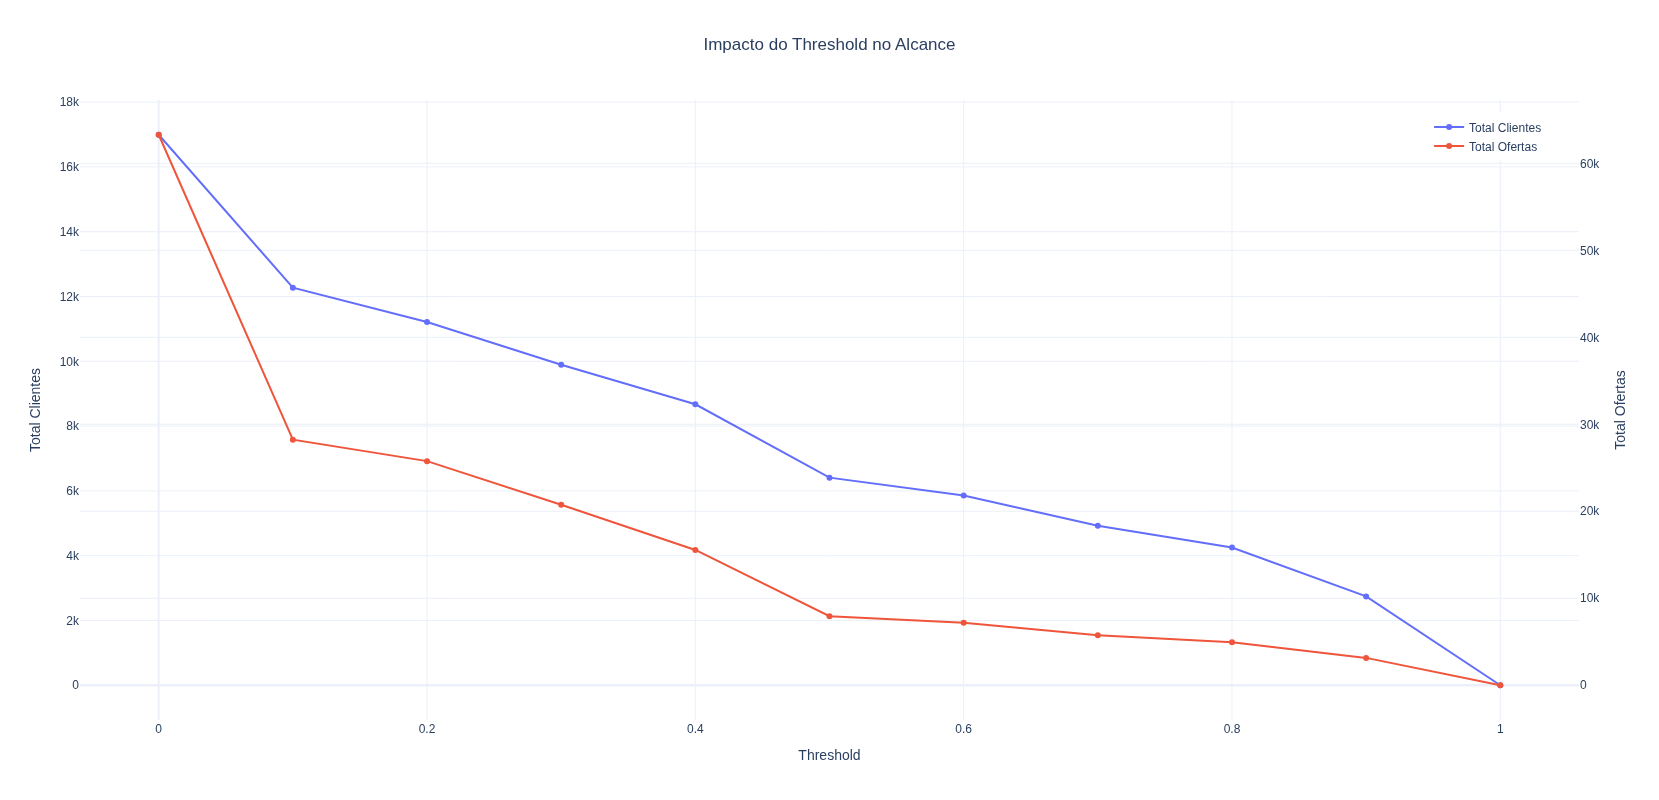

In [7]:
import pandas as pd
import plotly.graph_objects as go


thresholds = [round(x / 10, 1) for x in range(0, 11)] 

resultados = []
for t in thresholds:
    df_filt = df_offer_score.filter(F.col("offer_score") >= t)
    total_clientes = df_filt.select("client_id").distinct().count()
    total_ofertas = df_filt.count()
    resultados.append((t, total_clientes, total_ofertas))


df_plot = pd.DataFrame(resultados, columns=["Threshold", "Total Clientes", "Total Ofertas"])


fig = go.Figure()

fig.add_trace(go.Scatter(
    x=df_plot["Threshold"],
    y=df_plot["Total Clientes"],
    mode="lines+markers",
    name="Total Clientes",
    yaxis="y1"
))

fig.add_trace(go.Scatter(
    x=df_plot["Threshold"],
    y=df_plot["Total Ofertas"],
    mode="lines+markers",
    name="Total Ofertas",
    yaxis="y2"
))


fig.update_layout(
    title="Impacto do Threshold no Alcance",
    xaxis=dict(title="Threshold"),
    yaxis=dict(title="Total Clientes", side="left"),
    yaxis2=dict(title="Total Ofertas", overlaying="y", side="right"),
    legend=dict(x=0.9, y=0.98),
    template="plotly_white"
)

fig.update_layout(
    title=dict(x=0.5, xanchor="center"),
    height=800,
    width=1600
)

fig.show()


##### Escolherei 0.4, pois visualmente me informa que a degradação é maior acima desse limite

In [8]:
CUTOFF_SCORE = 0.4

df_recommended_offers = df_offer_score.filter(F.col("ranking") <= TOP_N_RECOMMENDATIONS)\
                                      .filter(F.col("offer_score") >= CUTOFF_SCORE)\
                                      .groupBy("client_id").agg(F.array_sort(F.collect_list(F.struct("ranking","offer_id","offer_type","offer_score"))).alias("items_sorted"))\
                                      .withColumn("recommended_offers", F.expr("transform(items_sorted, x -> x.offer_id)"))\
                                      .drop("items_sorted")\
                                      .orderBy('client_id')
df_recommended_offers.show(truncate=False)

+--------------------------------+------------------------------------------------------------------------------------------------------+
|client_id                       |recommended_offers                                                                                    |
+--------------------------------+------------------------------------------------------------------------------------------------------+
|0009655768c64bdeb2e877511632db8f|[f19421c1d4aa40978ebb69ca19b0e20d, fafdcd668e3743c1bb461111dcafc2a4, 2906b810c7d4411798c6938adc9daaa5]|
|0011e0d4e6b944f998e987f904e8c1e5|[9b98b8c7a33c4b65b9aebfe6a799e6d9]                                                                    |
|0020c2b971eb4e9188eac86d93036a77|[fafdcd668e3743c1bb461111dcafc2a4, 4d5c57ea9a6940dd891ad53e9dbe8da0]                                  |
|0020ccbbb6d84e358d3414a3ff76cffd|[2298d6c36e964ae4a3e7e9706d1fb8c2, 9b98b8c7a33c4b65b9aebfe6a799e6d9, f19421c1d4aa40978ebb69ca19b0e20d]|
|003d66b6608740288d6cc97a6903f4f0|

### Gerando Recomendações Intra-Cluster

In [9]:
df_km_predictions.show(5)

+--------------------+--------------------+----------------+------------------+----------------+----------+-------------------------+-------------------------+--------+--------+--------+--------+---------------+-----------------+---------------+---------------+--------------------+--------------+---------------+------------+----------+------+--------------------+--------------------+-------+
|           client_id|            offer_id|offer_type_index|qtd_offer_received|qtd_offer_viewed|sum_reward|registered_duration_month|registered_duration_years|gender_M|gender_F|gender_O|gender_U|age_group_index|credit_card_limit|category_limite|offer_min_value|offer_discount_value|offer_duration|qtd_transaction|total_amount|avg_amount|target|            features|     features_scaled|cluster|
+--------------------+--------------------+----------------+------------------+----------------+----------+-------------------------+-------------------------+--------+--------+--------+--------+---------------

In [10]:
df_clusters = df_km_predictions.select("client_id", "cluster").distinct()
df_clusters.show(5)

+--------------------+-------+
|           client_id|cluster|
+--------------------+-------+
|01e09d713abe4a36a...|      2|
|03deb7cf0ebd4c788...|      4|
|0ac73ba2449646378...|      0|
|0ae565c6ebc5417db...|      3|
|0b5e0b7de9bb42d9b...|      3|
+--------------------+-------+
only showing top 5 rows


In [11]:
df_cluster_offers = df_freq_bayes.select("client_id", "offer_id").distinct()\
                                 .join(df_clusters, on="client_id", how="inner")
df_cluster_offers.show(5, truncate=False)

+--------------------------------+--------------------------------+-------+
|client_id                       |offer_id                        |cluster|
+--------------------------------+--------------------------------+-------+
|0222d267445f4f078bc325224e471766|2906b810c7d4411798c6938adc9daaa5|0      |
|0251876076024444864473545adce065|2298d6c36e964ae4a3e7e9706d1fb8c2|4      |
|03575a43a3da4691998de01fff617f99|f19421c1d4aa40978ebb69ca19b0e20d|2      |
|036e4bedca2045afad50fda2d3b505ab|0b1e1539f2cc45b7b9fa7c272da2e1d7|0      |
|0485b8cb0bfc4d938895bbd6d8cbd7df|2906b810c7d4411798c6938adc9daaa5|1      |
+--------------------------------+--------------------------------+-------+
only showing top 5 rows


In [12]:
df_cluster_popular = df_cluster_offers.groupBy("cluster", "offer_id").count()\
                                      .withColumnRenamed("count", "qtd_clientes")
df_cluster_popular.show(5, truncate=False)

+-------+--------------------------------+------------+
|cluster|offer_id                        |qtd_clientes|
+-------+--------------------------------+------------+
|1      |fafdcd668e3743c1bb461111dcafc2a4|780         |
|0      |2906b810c7d4411798c6938adc9daaa5|1860        |
|3      |fafdcd668e3743c1bb461111dcafc2a4|1292        |
|0      |f19421c1d4aa40978ebb69ca19b0e20d|1864        |
|1      |3f207df678b143eea3cee63160fa8bed|800         |
+-------+--------------------------------+------------+
only showing top 5 rows


In [13]:
recs_cluster = df_clusters.join(df_cluster_popular, on="cluster", how="inner")\
                          .join(df_freq_bayes.select("client_id", "offer_id").distinct(), on=["client_id", "offer_id"], how="left_anti")\
                          .withColumn("ranking", F.row_number().over(Window.partitionBy("client_id")\
                                                                           .orderBy(F.col("qtd_clientes").desc())))\
                          .distinct().orderBy('client_id', "cluster", F.desc("qtd_clientes"))\
                          .filter(F.col("ranking") <= TOP_N_CLUSTER_RECOMMENDATIONS)
recs_cluster.show(truncate=False)

+--------------------------------+--------------------------------+-------+------------+-------+
|client_id                       |offer_id                        |cluster|qtd_clientes|ranking|
+--------------------------------+--------------------------------+-------+------------+-------+
|0009655768c64bdeb2e877511632db8f|9b98b8c7a33c4b65b9aebfe6a799e6d9|0      |1900        |1      |
|0009655768c64bdeb2e877511632db8f|0b1e1539f2cc45b7b9fa7c272da2e1d7|0      |1898        |2      |
|0009655768c64bdeb2e877511632db8f|4d5c57ea9a6940dd891ad53e9dbe8da0|0      |1885        |3      |
|00116118485d4dfda04fdbaba9a87b5c|2298d6c36e964ae4a3e7e9706d1fb8c2|1      |812         |1      |
|00116118485d4dfda04fdbaba9a87b5c|4d5c57ea9a6940dd891ad53e9dbe8da0|1      |812         |2      |
|00116118485d4dfda04fdbaba9a87b5c|9b98b8c7a33c4b65b9aebfe6a799e6d9|1      |808         |3      |
|0011e0d4e6b944f998e987f904e8c1e5|fafdcd668e3743c1bb461111dcafc2a4|0      |1895        |1      |
|0011e0d4e6b944f998e987f904e8c

In [14]:
df_recommended_cluster_offers = recs_cluster.join(df_offer_score.select("client_id", "offer_id").distinct(), on=["client_id", "offer_id"], how="left_anti")\
                                            .groupBy("client_id").agg(F.array_sort(F.collect_list(F.struct("ranking","offer_id"))).alias("cluster_offer_sorted"))\
                                            .withColumn("recommended_cluster_offers", F.expr("transform(cluster_offer_sorted, x -> x.offer_id)"))\
                                            .drop("cluster_offer_sorted")\
                                            .orderBy('client_id')
df_recommended_cluster_offers.show(truncate=False)

+--------------------------------+------------------------------------------------------------------------------------------------------+
|client_id                       |recommended_cluster_offers                                                                            |
+--------------------------------+------------------------------------------------------------------------------------------------------+
|0009655768c64bdeb2e877511632db8f|[9b98b8c7a33c4b65b9aebfe6a799e6d9, 0b1e1539f2cc45b7b9fa7c272da2e1d7, 4d5c57ea9a6940dd891ad53e9dbe8da0]|
|00116118485d4dfda04fdbaba9a87b5c|[2298d6c36e964ae4a3e7e9706d1fb8c2, 4d5c57ea9a6940dd891ad53e9dbe8da0, 9b98b8c7a33c4b65b9aebfe6a799e6d9]|
|0011e0d4e6b944f998e987f904e8c1e5|[fafdcd668e3743c1bb461111dcafc2a4, 4d5c57ea9a6940dd891ad53e9dbe8da0, f19421c1d4aa40978ebb69ca19b0e20d]|
|0020c2b971eb4e9188eac86d93036a77|[0b1e1539f2cc45b7b9fa7c272da2e1d7, 2298d6c36e964ae4a3e7e9706d1fb8c2, 2906b810c7d4411798c6938adc9daaa5]|
|0020ccbbb6d84e358d3414a3ff76cffd|

### Pegando as Top Ofertas mais adiquiridas pelos clientes por tipo de oferta e recomendando para complementar o pacote de recomendações

In [15]:
df_freq_bayes.show(5)

+--------------------+-------------+--------------------+-------------------+----------------+----------+
|           client_id|   offer_type|            offer_id|qtd_offer_completed|offer_type_count|freq_bayes|
+--------------------+-------------+--------------------+-------------------+----------------+----------+
|0009655768c64bdeb...|     discount|2906b810c7d441179...|                  1|               2|       0.5|
|0009655768c64bdeb...|informational|3f207df678b143eea...|                  0|               2|       0.0|
|0009655768c64bdeb...|informational|5a8bc65990b245e5a...|                  0|               2|       0.0|
|0009655768c64bdeb...|         bogo|f19421c1d4aa40978...|                  1|               1|       1.0|
|0009655768c64bdeb...|     discount|fafdcd668e3743c1b...|                  1|               2|       0.5|
+--------------------+-------------+--------------------+-------------------+----------------+----------+
only showing top 5 rows


In [16]:
popular_offers = df_freq_bayes.groupBy("offer_id", "offer_type").agg(F.sum("qtd_offer_completed").alias("qtd_offer_completed"))\
                              .filter("qtd_offer_completed > 0")\
                              .withColumn("ranking", F.row_number().over(Window.partitionBy("offer_type")\
                                                                               .orderBy(F.col("qtd_offer_completed").desc())))\
                              .filter(F.col("ranking") <= TOP_N_OFFERS)

popular_offers.show(truncate=False)

+--------------------------------+----------+-------------------+-------+
|offer_id                        |offer_type|qtd_offer_completed|ranking|
+--------------------------------+----------+-------------------+-------+
|9b98b8c7a33c4b65b9aebfe6a799e6d9|bogo      |4354               |1      |
|f19421c1d4aa40978ebb69ca19b0e20d|bogo      |4296               |2      |
|fafdcd668e3743c1bb461111dcafc2a4|discount  |5317               |1      |
|2298d6c36e964ae4a3e7e9706d1fb8c2|discount  |5156               |2      |
+--------------------------------+----------+-------------------+-------+



In [17]:
recs_popular_offers = df_offer_score.filter(F.col("y_proba_class1") >= THRESH)\
                                    .select("client_id", "offer_type").distinct()\
                                    .join(popular_offers.select("offer_id", "offer_type", "ranking"), on='offer_type', how="inner")\
                                    .orderBy('client_id')

recs_popular_offers.show(5, truncate=False)

+----------+--------------------------------+--------------------------------+-------+
|offer_type|client_id                       |offer_id                        |ranking|
+----------+--------------------------------+--------------------------------+-------+
|bogo      |0009655768c64bdeb2e877511632db8f|f19421c1d4aa40978ebb69ca19b0e20d|2      |
|bogo      |0009655768c64bdeb2e877511632db8f|9b98b8c7a33c4b65b9aebfe6a799e6d9|1      |
|discount  |0009655768c64bdeb2e877511632db8f|fafdcd668e3743c1bb461111dcafc2a4|1      |
|discount  |0009655768c64bdeb2e877511632db8f|2298d6c36e964ae4a3e7e9706d1fb8c2|2      |
|discount  |0020c2b971eb4e9188eac86d93036a77|fafdcd668e3743c1bb461111dcafc2a4|1      |
+----------+--------------------------------+--------------------------------+-------+
only showing top 5 rows


In [18]:
df_recommended_popular_offers = recs_popular_offers.join(df_offer_score.select("client_id", "offer_id").distinct(), on=["client_id", "offer_id"], how="left_anti")\
                                                   .join(recs_cluster.select("client_id", "offer_id").distinct(), on=["client_id", "offer_id"], how="left_anti")\
                                                   .groupBy("client_id").agg(F.array_sort(F.collect_list(F.struct("ranking","offer_id"))).alias("popular_offer_sorted"))\
                                                   .withColumn("recommended_popular_offers", F.expr("transform(popular_offer_sorted, x -> x.offer_id)"))\
                                                   .drop("popular_offer_sorted")\
                                                   .orderBy('client_id')

df_recommended_popular_offers.show(truncate=False)

+--------------------------------+--------------------------------------------------------------------+
|client_id                       |recommended_popular_offers                                          |
+--------------------------------+--------------------------------------------------------------------+
|0009655768c64bdeb2e877511632db8f|[2298d6c36e964ae4a3e7e9706d1fb8c2]                                  |
|0020c2b971eb4e9188eac86d93036a77|[9b98b8c7a33c4b65b9aebfe6a799e6d9, f19421c1d4aa40978ebb69ca19b0e20d]|
|0020ccbbb6d84e358d3414a3ff76cffd|[fafdcd668e3743c1bb461111dcafc2a4]                                  |
|004c5799adbf42868b9cff0396190900|[9b98b8c7a33c4b65b9aebfe6a799e6d9]                                  |
|00715b6e55c3431cb56ff7307eb19675|[9b98b8c7a33c4b65b9aebfe6a799e6d9, f19421c1d4aa40978ebb69ca19b0e20d]|
|0091d2b6a5ea4defaa8393e4e816db60|[9b98b8c7a33c4b65b9aebfe6a799e6d9, 2298d6c36e964ae4a3e7e9706d1fb8c2]|
|00ae03011f9f49b8a4b3e6d416678b0b|[9b98b8c7a33c4b65b9aebfe6a799e

### Juntando recomendações vindas dos Scores, com recomendações de popularidade e Recomendações IntraCluster

In [19]:
df_allocation = df_freq_bayes.select('client_id').distinct()\
                             .join(df_recommended_offers, on='client_id', how='left')\
                             .join(df_recommended_cluster_offers, on='client_id', how='left')\
                             .join(df_recommended_popular_offers, on='client_id', how='left')\
                             .withColumn("recommended_offers", F.coalesce(F.col("recommended_offers"), F.array().cast(T.ArrayType(T.StringType()))))\
                             .withColumn("recommended_popular_offers", F.coalesce(F.col("recommended_popular_offers"), F.array().cast(T.ArrayType(T.StringType()))))\
                             .withColumn("recommended_cluster_offers", F.coalesce(F.col("recommended_cluster_offers"), F.array().cast(T.ArrayType(T.StringType()))))\
                             .orderBy('client_id')
df_allocation.show()

+--------------------+--------------------+--------------------------+--------------------------+
|           client_id|  recommended_offers|recommended_cluster_offers|recommended_popular_offers|
+--------------------+--------------------+--------------------------+--------------------------+
|0009655768c64bdeb...|[f19421c1d4aa4097...|      [9b98b8c7a33c4b65...|      [2298d6c36e964ae4...|
|00116118485d4dfda...|                  []|      [2298d6c36e964ae4...|                        []|
|0011e0d4e6b944f99...|[9b98b8c7a33c4b65...|      [fafdcd668e3743c1...|                        []|
|0020c2b971eb4e918...|[fafdcd668e3743c1...|      [0b1e1539f2cc45b7...|      [9b98b8c7a33c4b65...|
|0020ccbbb6d84e358...|[2298d6c36e964ae4...|      [0b1e1539f2cc45b7...|      [fafdcd668e3743c1...|
|003d66b6608740288...|[fafdcd668e3743c1...|      [9b98b8c7a33c4b65...|                        []|
|00426fe3ffde4c6b9...|                  []|      [3f207df678b143ee...|                        []|
|004b041fbfe448599..

In [20]:
print(f"Clientes recebendo recomendação de algum nivel: {df_allocation.select('client_id').distinct().count()}")
print(f"Clientes recebendo recomendação pelo offer_score: {df_allocation.filter(F.size(F.col("recommended_offers")) != 0).count()}")
print(f"Clientes recebendo recomendação pelo Cluster: {df_allocation.filter(F.size(F.col("recommended_cluster_offers")) != 0).count()}")
print(f"Clientes recebendo recomendação pela Popularidade da Oferta: {df_allocation.filter(F.size(F.col("recommended_popular_offers")) != 0).count()}")

Clientes recebendo recomendação de algum nivel: 16994
Clientes recebendo recomendação pelo offer_score: 8674
Clientes recebendo recomendação pelo Cluster: 16994
Clientes recebendo recomendação pela Popularidade da Oferta: 3496


In [21]:
df_allocation.write.format("parquet").mode("overwrite").save(path_output_allocation)